In [17]:
import torch
import numpy as np
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt
from transformers import BertTokenizerFast
from sklearn.model_selection import train_test_split

In [19]:
df = pd.read_csv('train.csv')
df =df.dropna()

In [22]:
train_old, temp_old, train_new, temp_new = train_test_split(df['old'], df['new'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3)
val_old, test_old, val_new, test_new = train_test_split(temp_old, temp_new, 
                                                                random_state=2018, 
                                                                test_size=0.5) 

In [23]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device("cuda")

In [24]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

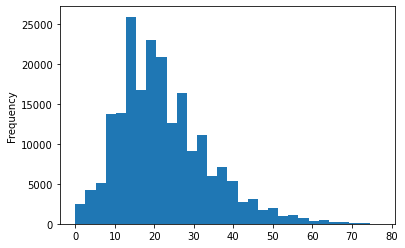

In [25]:
seq_len = [len(str(i).split()) for i in train_old]
pd.Series(seq_len).plot.hist(bins = 30).plot()
plt.show()

Tokens for training and validation

In [1]:
from torchtext.datasets import WikiText2
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

train_iter = WikiText2(split='train')
tokenizer = get_tokenizer('basic_english')
vocab = build_vocab_from_iterator(map(tokenizer, train_iter), specials=['<unk>'])
vocab.set_default_index(vocab['<unk>']) 

c:\Users\psiml\Documents\projekat\.data\WikiText2\wikitext-2-v1.zip: 100%|██████████| 4.48M/4.48M [00:00<00:00, 6.59MB/s]


In [5]:
len(vocab)

28782

In [29]:
oldTrainTokens = tokenizer.batch_encode_plus(
    train_old.to_list(),
    max_length = 32,
    padding = 'max_length',
    truncation=True
)
newTrainTokens = tokenizer.batch_encode_plus(
    train_new.to_list(),
    max_length = 32,
    padding = 'max_length',
    truncation=True
)
oldValTokens = tokenizer.batch_encode_plus(
    val_old.to_list(),
    max_length = 32,
    padding = 'max_length',
    truncation=True
)
newValTokens = tokenizer.batch_encode_plus(
    val_new.to_list(),
    max_length = 32,
    padding = 'max_length',
    truncation=True
)

oldTestTokens = tokenizer.batch_encode_plus(
    test_old.to_list(),
    max_length = 32,
    padding = 'max_length',
    truncation=True
)
newTestTokens = tokenizer.batch_encode_plus(
    test_new.to_list(),
    max_length = 32,
    padding = 'max_length',
    truncation=True
)


In [37]:
totensor = torch.tensor(oldTrainTokens['input_ids'])
tntensor = torch.tensor(newTrainTokens['input_ids'])

tomask = torch.tensor(oldTrainTokens['attention_mask'])
tnmask = torch.tensor(newTrainTokens['attention_mask'])

votensor = torch.tensor(oldValTokens['input_ids'])
vntensor = torch.tensor(newValTokens['input_ids'])

vomask = torch.tensor(oldValTokens['attention_mask'])
vnmask = torch.tensor(newValTokens['attention_mask'])

testotensor = torch.tensor(oldTestTokens['input_ids'])
testntensor = torch.tensor(newTestTokens['input_ids'])

testomask = torch.tensor(oldTestTokens['attention_mask'])
testnmask = torch.tensor(newTestTokens['attention_mask'])

In [38]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
batch_size = 32
trainData = TensorDataset(totensor, tntensor, tomask, tnmask)
valData = TensorDataset(votensor, vntensor, vomask, vnmask)
testData = TensorDataset(testotensor, testntensor, testomask, testnmask)

In [39]:
trainSampler = RandomSampler(trainData)
valSampler = RandomSampler(valData)
testSampler = RandomSampler(testData)

In [40]:
trainDataloader = DataLoader(trainData, sampler=trainSampler, batch_size=batch_size)
valDataloader = DataLoader(valData, sampler=valSampler, batch_size=batch_size)
trainDataloader = DataLoader(testData, sampler=testSampler, batch_size=batch_size)

In [54]:
from TransformerModel import Transformer

model = Transformer()
model = model.to(device = device)

from transformers import AdamW
optimizer = AdamW(model.parameters(), lr = 1e-5)
crossEntropy = nn.CrossEntropyLoss()
epochs = 10

In [52]:
def train():
  
    model.train()

    total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
    total_preds=[]
  
  # iterate over batches
    for step,batch in enumerate(trainDataloader):
        if step % 50 == 0 and not step == 0:
          print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(trainDataloader)))

    # push the batch to gpu
        batch = [r.to(device) for r in batch]
        
        old_id, new_id, old_mask, new_mask = batch
        old_id = old_id[:,:-1]
        new_id = new_id[:,1:]
        model.zero_grad()
        tgt_mask = model.get_tgt_mask(32)
        output = model(old_id, new_id,tgt_mask = tgt_mask,src_pad_mask =  old_mask,tgt_pad_mask = new_mask)
        loss = crossEntropy(new_id, output)
        print(loss)

In [53]:
train()

TypeError: forward() got an unexpected keyword argument 'tgt_mask'